In [1]:
# %%
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from pathlib import Path
from scipy.signal import savgol_filter

plt.rcParams["axes.grid"] = True

# === AJUSTA estas rutas a tus CSV de PASTAS ===
FILES = {
    "0%":   r"./mnt/pasta/Prueba_UnaTermo_01sep2025_2037_0PLR.csv",
    "7.5%": r"./mnt/pasta/Prueba_UnaTermo_03sep2025_1745_7PLR.csv",
    "15%":  r"./mnt/pasta/Prueba_UnaTermo_05sep2025_1330_15PLR.csv",
    "30%":  r"./mnt/pasta/Prueba_UnaTermo_06sep2025_1234_30PLR.csv",
}

OUTDIR = Path("./salidas_pastas_grises_24h_vf")
OUTDIR.mkdir(exist_ok=True)

# Grises y marcadores (comparativa)
GRAY_TC   = "0.15"
GRAY_COMP = {"0%":"0.15","7.5%":"0.35","15%":"0.55","30%":"0.75"}
MARK_COMP = {"0%":"o","7.5%":"s","15%":"^","30%":"D"}


In [5]:
# %%
COLUMN_TC = "Temp1 (°C)"   # <-- cámbialo si tu CSV usa otro nombre (p.ej. "Temp (°C)")

def ensure_odd(k: int) -> int:
    return k if k % 2 == 1 else k + 1

def load_pasta_exact(path: str, col_tc: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Timestamp" not in df.columns or col_tc not in df.columns:
        raise ValueError(f"{path}: se esperaban columnas 'Timestamp' y '{col_tc}'. Presentes: {list(df.columns)}")

    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df[col_tc] = pd.to_numeric(df[col_tc], errors="coerce")
    df = df.dropna(subset=["Timestamp"]).sort_values("Timestamp").set_index("Timestamp")
    df = df.rename(columns={col_tc: "tc"})
    return df[["tc"]]

def smooth_resample_trim(df: pd.DataFrame, freq="2s", window=31, sg_window=61, sg_poly=3) -> pd.DataFrame:
    """
    1) Remuestreo 2s + interpolación temporal
    2) Mediana centrada -> Media centrada
    3) Savitzky-Golay (window=61, polyorder=3)
    4) Tiempo relativo y recorte 0–24h
    """
    window = ensure_odd(window)
    if sg_window != 0: sg_window = ensure_odd(sg_window)

    dfr = df.resample(freq).mean()
    dfr["tc"] = dfr["tc"].interpolate("time", limit_direction="both")

    med = dfr["tc"].rolling(window=window, center=True, min_periods=max(3, window//3)).median()
    mea = med.rolling(window=window, center=True, min_periods=max(3, window//3)).mean()
    dfr["tc_smooth"] = mea

    arr = dfr["tc_smooth"].to_numpy()
    if sg_window and np.isfinite(arr).sum() >= sg_window:
        try:
            dfr["tc_sg"] = savgol_filter(arr, window_length=sg_window, polyorder=sg_poly, mode="interp")
        except Exception:
            dfr["tc_sg"] = dfr["tc_smooth"]
    else:
        dfr["tc_sg"] = dfr["tc_smooth"]

    t0 = dfr.index[0]
    dfr["tiempo_rel_min"] = (dfr.index - t0).total_seconds()/60.0
    dfr = dfr.loc[dfr["tiempo_rel_min"] <= 22*60]
    dfr["tiempo_rel_h"] = dfr["tiempo_rel_min"]/60.0
    return dfr


In [15]:
# %%
def add_peak_vertical(ax, xh_peak: float, y_peak: float, color="0.15"):
    """Línea punteada vertical desde el eje X hasta y_peak (usa fracción del eje para tocar el eje)."""
    y0, y1 = ax.get_ylim()
    if y1 == y0:
        return
    frac = (y_peak - y0) / (y1 - y0)
    frac = max(0.0, min(1.0, frac))
    ax.axvline(
        xh_peak, ymin=0.0, ymax=frac,
        color=color, linestyle=(0, (4, 4)), linewidth=0.9, alpha=0.65, zorder=1
    )

def label_tmax_topleft(ax, xh_peak: float, y_peak: float, color="0.15", text_prefix="Tmáx"):
    """Etiqueta compacta en esquina superior izquierda con flecha hacia el pico (sin hora)."""
    txt = f"{text_prefix} {y_peak:.1f} °C"
    ax.annotate(
        txt, xy=(xh_peak, y_peak), xytext=(0.98, 0.98), textcoords="axes fraction",
        ha="right", va="top", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec=color, alpha=0.95),
        arrowprops=dict(arrowstyle="->", color=color, lw=1.0),
        color="black", zorder=6
    )

def label_tmax_topright(ax, x, y, text_prefix="Tmáx"):
    ax.scatter([x], [y])
    ax.axvline(x, linestyle="--", linewidth=1)
    ax.annotate(
        f"{text_prefix}={y:.2f}°C\n@ {x:.2f} h",
        xy=(x, y),
        xytext=(x + 0.5, y + 0.3),
        textcoords="data",
        arrowprops=dict(arrowstyle="->", lw=0.8),
        ha="left", va="bottom"
    )


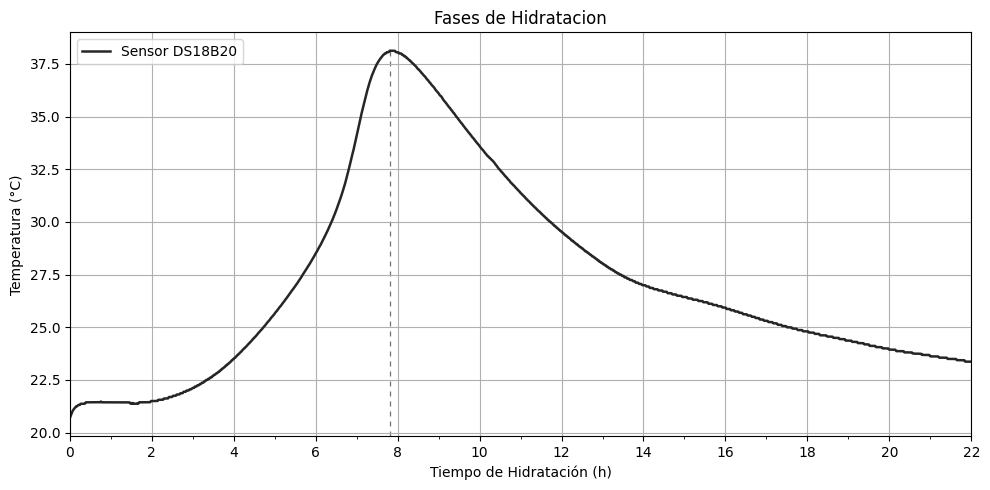

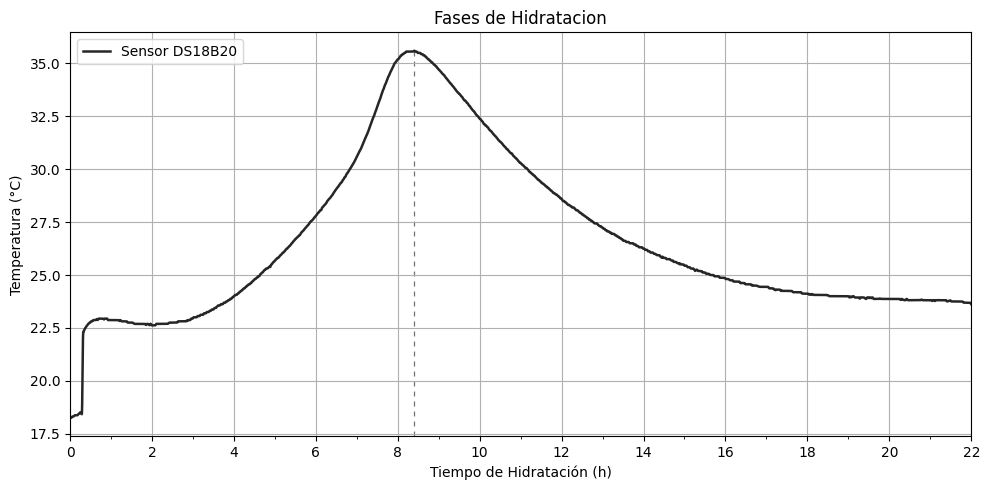

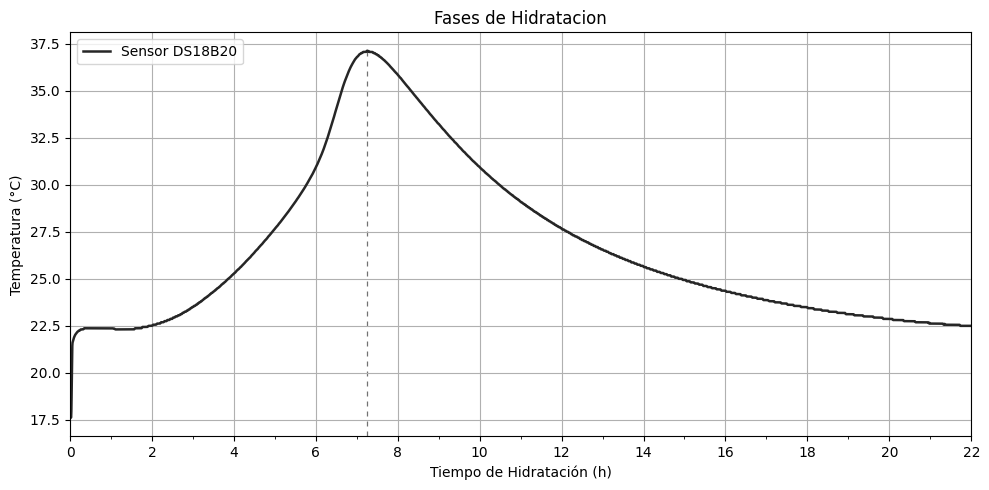

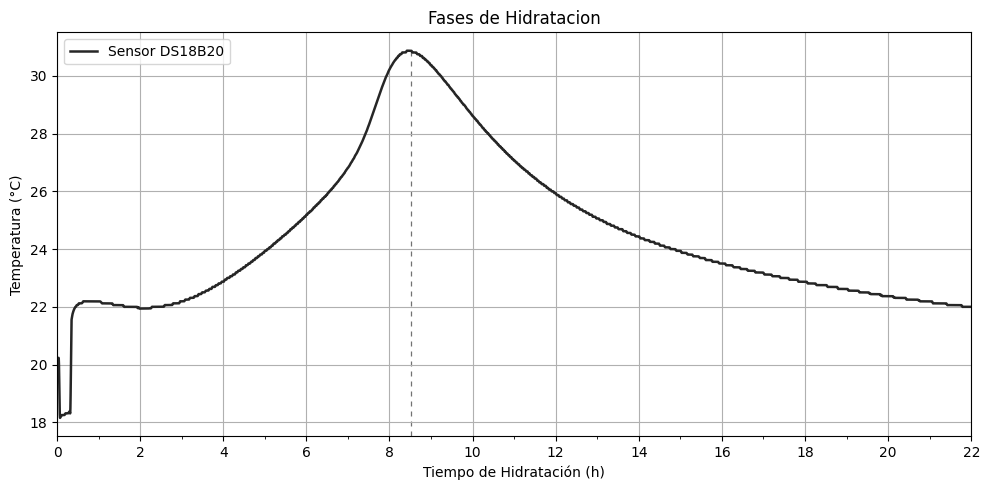

In [22]:
# %%
processed = {}

for label, path in FILES.items():
    p = Path(path)
    if not p.exists():
        print(f"[WARN] no existe: {p}")
        continue

    df = load_pasta_exact(str(p), COLUMN_TC)
    ds = smooth_resample_trim(df, freq="2s", window=31, sg_window=61, sg_poly=3)
    processed[label] = ds

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(ds["tiempo_rel_h"], ds["tc_sg"], color=GRAY_TC, linewidth=1.8, label="Sensor DS18B20")

    # Ejes (0–24 h, ticks cada 2 h) y leyenda arriba-derecha
    ax.set_title("Fases de Hidratacion")
    ax.set_xlabel("Tiempo de Hidratación (h)")
    ax.set_ylabel("Temperatura (°C)")
    ax.set_xlim(0, 22)
    ax.xaxis.set_major_locator(MultipleLocator(2.0))
    ax.xaxis.set_minor_locator(MultipleLocator(1.0))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):d}" if 0 <= x <= 24 else ""))
    ax.legend(loc="upper left", frameon=True)

    # Pico (Tmáx) + línea vertical + etiqueta
    idx_max = int(np.nanargmax(ds["tc_sg"].to_numpy()))
    xh_peak = float(ds["tiempo_rel_h"].iloc[idx_max])
    y_peak  = float(ds["tc_sg"].iloc[idx_max])
    add_peak_vertical(ax, xh_peak, y_peak, color=GRAY_TC)
    
  

    fig.tight_layout()
    plt.show()
    fig.savefig(OUTDIR / f"{label.replace('%','pct')}_pasta_tc_24h.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

    # Export limpio
    ds[["tiempo_rel_min","tiempo_rel_h","tc","tc_sg"]].to_csv(
        OUTDIR / f"{label.replace('%','pct')}_pasta_clean_24h.csv", index_label="timestamp"
    )


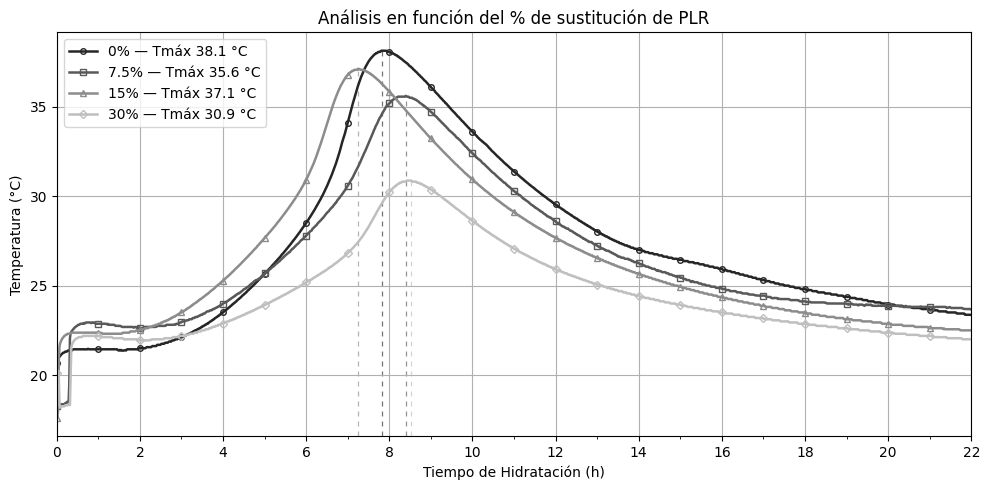

In [25]:
# %%
labels_presentes = [k for k in ["0%","7.5%","15%","30%"] if k in processed]
if len(labels_presentes) >= 2:
    # Rejilla común 0–24 h, cada 1 min
    max_rel_h = min(processed[k]["tiempo_rel_h"].max() for k in labels_presentes)
    max_rel_h = min(max_rel_h, 24.0)
    grid_h = np.arange(0, max_rel_h, 1.0/60.0)

    fig, ax = plt.subplots(figsize=(10,5))
    peaks = []

    for label in ["0%","7.5%","15%","30%"]:
        if label not in processed: 
            continue
        d = processed[label]
        x = d["tiempo_rel_h"].to_numpy()
        y = d["tc_sg"].to_numpy()
        yi = np.interp(grid_h, x, y)

        # Tmáx
        i_peak = int(np.nanargmax(yi))
        xh_pk  = float(grid_h[i_peak])
        y_pk   = float(yi[i_peak])
        peaks.append((label, xh_pk, y_pk))

        # Curva en grises + marcadores discretos cada 1 h
        ax.plot(grid_h, yi,
                color=GRAY_COMP[label], linestyle="-",
                linewidth=1.8, marker=MARK_COMP[label],
                markevery=60, markersize=4,
                markerfacecolor="none", markeredgecolor=GRAY_COMP[label],
                label=f"{label} — Tmáx {y_pk:.1f} °C",
                zorder=2)

    # Ejes y leyenda (arriba-izquierda)
    ax.set_title("Análisis en función del % de sustitución de PLR")
    ax.set_xlabel("Tiempo de Hidratación (h)")
    ax.set_ylabel("Temperatura (°C)")
    ax.set_xlim(0, 22)
    ax.xaxis.set_major_locator(MultipleLocator(2.0))
    ax.xaxis.set_minor_locator(MultipleLocator(1.0))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):d}" if 0 <= x <= 24 else ""))
    ax.legend(loc="upper left", frameon=True)

    # Líneas punteadas verticales para cada Tmáx
    y0, y1 = ax.get_ylim()
    for label, xh_pk, y_pk in peaks:
        frac = 0.0 if y1 == y0 else max(0.0, min(1.0, (y_pk - y0)/(y1 - y0)))
        ax.axvline(
            xh_pk, ymin=0.0, ymax=frac,
            color=GRAY_COMP[label], linestyle=(0, (4, 4)), linewidth=0.9, alpha=0.65, zorder=1
        )

    fig.tight_layout()
    plt.show()
    fig.savefig(OUTDIR / "comparativa_pastas_tc_gris_Tmax_vlines.png", dpi=300, bbox_inches="tight")
    plt.close(fig)
else:
    print("[INFO] Se necesitan al menos dos archivos para la comparativa.")
